<a href="https://colab.research.google.com/github/mohiteprathamesh1996/Investment-and-Portfolio-Analysis-of-Stocks/blob/main/PortfolioOpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing packages

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import requests
import json
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

!pip install PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

#### Fetching 4 of the most recent statements of each assets 

In [2]:
def fetch_statement_latest_4_QTRs(ticker):
  '''
  Returns statements of a given asset from previous 4 quarters.
  
  Parameters:
  -----------  
      ticker: str
          Stock ticker.    
  '''
  # Requesting data using website API
  statement = requests.get('https://financialmodelingprep.com/api/v3/balance-sheet-statement/{}?period=quarter&limit=400&apikey=28dd29191adc89c51754e4ee2b06aa56'.format(ticker))
  
  # Create dataframe
  statement = pd.DataFrame(statement.json())
  statement["fillingDate"] = pd.to_datetime(statement["fillingDate"])
  statement["cycle"] = statement["period"]+"_"+statement["fillingDate"].dt.year.astype(str)
  
  # Extract details from previous most recent statements  
  statement = statement.set_index("fillingDate")[["totalAssets","totalLiabilities","totalStockholdersEquity"]].head(4)

  return statement.sort_index(ascending=True)

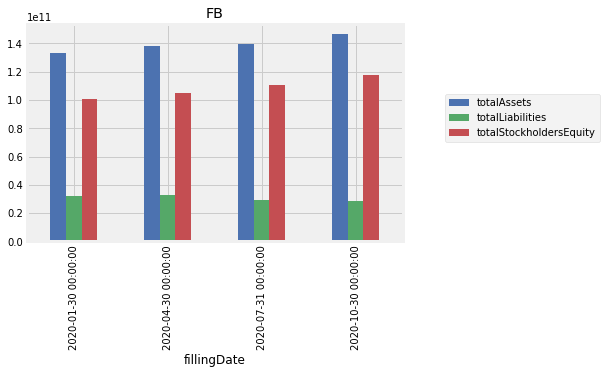


**********************************************************************


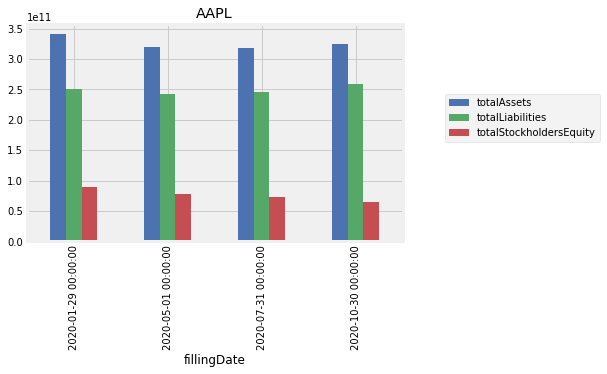


**********************************************************************


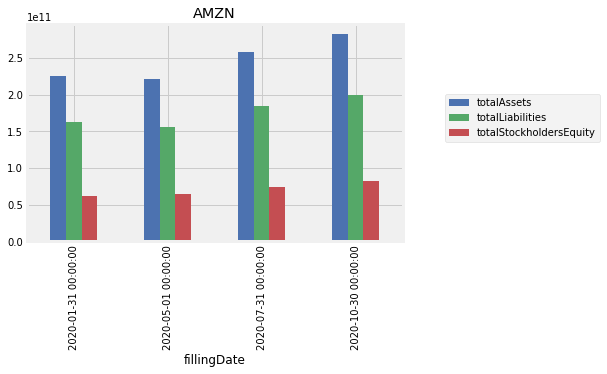


**********************************************************************


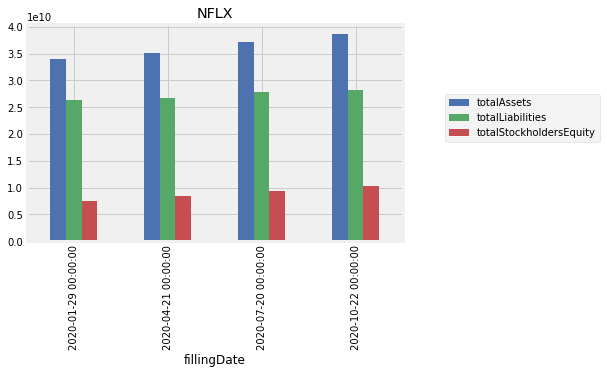


**********************************************************************


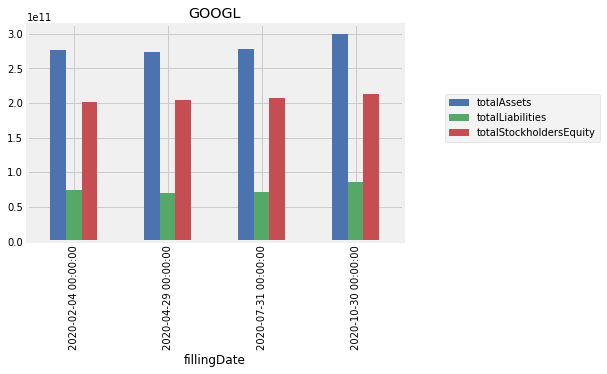


**********************************************************************


In [3]:
for ticker in ["FB","AAPL","AMZN","NFLX","GOOGL"]:
  statement = fetch_statement_latest_4_QTRs(ticker)
  statement.plot(kind="bar")
  plt.title(ticker)
  plt.legend(bbox_to_anchor=(1.1, 0.7))
  plt.show()
  print("\n**********************************************************************")

#### Get returns and risk at status quo 

In [4]:
def ideal_return_volatility(list_of_assets):
  # Assign equal weightage to each asset
  assign_weights = np.array([1/len(list_of_assets) for i in list_of_assets])

  # Fetch live data
  df = pdr.get_data_yahoo(list_of_assets, 
                          start=str(datetime.date.today()-datetime.timedelta(days=365)),
                          end=str(datetime.date.today()))["Adj Close"]
  
  # Get per day return %
  returns = df.pct_change()

  # Get annual covariance matrix
  annual_cov_matrix = returns.cov() * df.shape[0]
  
  # Calculate net portfolio variance
  portfolio_variance = np.dot(assign_weights.T, np.dot(annual_cov_matrix, assign_weights))
  
  # Calculate net portfolio volatility
  portfolio_volatility = np.sqrt(portfolio_variance)
  
  # Calculate simple annual return
  simple_annual_return = np.sum(returns.mean()*assign_weights) * df.shape[0]
  
  print("Expected annual return = ",round(simple_annual_return*100, 2), "%")
  print("Annual volatility = ",round(portfolio_volatility*100, 2), "%") 

#### Optimizing the portfolio of assets with an objective to maximize returns given other risks

In [5]:
def optimized_portfolio(list_of_assets, budget):
  '''
  Runs a simulation to generate portfolio of assets with an objective to maximize returns given other risks.
  
  Parameters:
  -----------  
      list_of_assets: list
          all the assets that are to be pulled from pandas datareader to comprise.    
      
      budget: int 
          amount of investment in US $.

  '''
  # Fetch live data
  df = pdr.get_data_yahoo(list_of_assets, 
                          start=str(datetime.date.today()-datetime.timedelta(days=365)),
                          end=str(datetime.date.today()))["Adj Close"]

  # Get the latest price
  latest_price = get_latest_prices(df)

  # Get average expected return
  mean_expected_return = expected_returns.mean_historical_return(df)

  # Generate sample covariance matrix to measure relative price fluctuation
  sample_covariance_matrix = risk_models.sample_cov(df)

  plt.rcParams["figure.figsize"] = (10, 5)
  plt.rcParams["font.size"] = 12
  plot_efficient_frontier(CLA(mean_expected_return, sample_covariance_matrix))
  plt.show()

  print("\n At a given budget of USD ${}, \n".format(budget))


  # Fitting the Efficient Frontier to obtain optimized weights for each asset
  print("If Objective -> Optimized Portfolio to Maximize Expected Return: \n")
  ef_max_sharpe = EfficientFrontier(mean_expected_return, sample_covariance_matrix)
  clean_weights_max_sharpe = ef_max_sharpe.max_sharpe()
  print(clean_weights_max_sharpe)
  ef_max_sharpe.portfolio_performance(verbose=True)
  print("\nProposed discrete allocation plan")
  d_allocate = DiscreteAllocation(clean_weights_max_sharpe, latest_price, total_portfolio_value=budget)
  allocated, balance = d_allocate.greedy_portfolio()
  print(allocated)
  print("Remaining Balance = $", round(balance, 2))
  
  
  print("\n*****************************************************************************************\n")
  print("If Objective -> Optimized Portfolio to Minimize Volatility: \n")
  ef_min_risk = EfficientFrontier(mean_expected_return, sample_covariance_matrix)
  clean_weights_min_risk = ef_min_risk.min_volatility()
  print(clean_weights_min_risk)
  ef_min_risk.portfolio_performance(verbose=True)
  print("\nProposed discrete allocation plan")
  d_allocate = DiscreteAllocation(clean_weights_min_risk, latest_price, total_portfolio_value=budget)
  allocated, balance = d_allocate.greedy_portfolio()
  print(allocated)
  print("Remaining Balance = $", round(balance, 2))

In [6]:
assets = ["CRM", "CRWD", "ETSY", "QRVO", "JD", "TTM"]

In [7]:
ideal_return_volatility(list_of_assets=["FB","AMZN","AAPL","NFLX","GOOGL"])

Expected annual return =  58.37 %
Annual volatility =  37.03 %


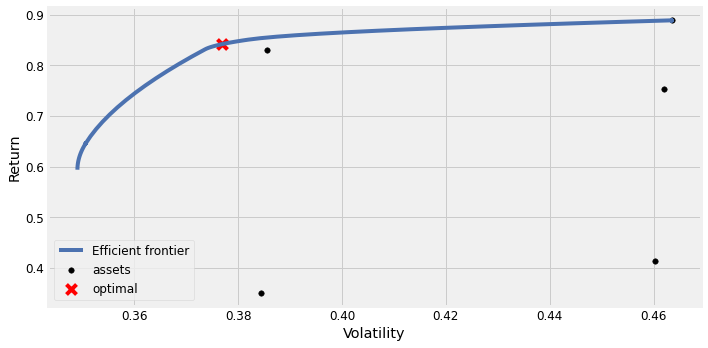


 At a given budget of USD $10000, 

If Objective -> Optimized Portfolio to Maximize Expected Return: 

OrderedDict([('FB', 0.0), ('AMZN', 0.6514816358750192), ('AAPL', 0.2813587757552835), ('NFLX', 0.0671595883696971), ('GOOGL', 0.0)])
Expected annual return: 84.2%
Annual volatility: 37.7%
Sharpe Ratio: 2.18

Proposed discrete allocation plan
{'AMZN': 2, 'AAPL': 22, 'NFLX': 1}
Remaining Balance = $ 396.4

*****************************************************************************************

If Objective -> Optimized Portfolio to Minimize Volatility: 

OrderedDict([('FB', 0.0), ('AMZN', 0.3820124687594226), ('AAPL', 0.0), ('NFLX', 0.148014995363523), ('GOOGL', 0.4699725358770545)])
Expected annual return: 59.4%
Annual volatility: 34.9%
Sharpe Ratio: 1.64

Proposed discrete allocation plan
{'GOOGL': 2, 'AMZN': 1, 'NFLX': 3}
Remaining Balance = $ 1662.07


In [8]:
optimized_portfolio(list_of_assets=["FB","AMZN","AAPL","NFLX","GOOGL"], budget=10000)